引入函式

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, auc
from scipy.spatial.distance import mahalanobis
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import ADASYN

載入資料

In [ ]:
file_path = 'Final Transactions.csv'
data = pd.read_csv(file_path)
print(f"資料載入完成，形狀：{data.shape}")

特徵工程

In [ ]:
data['TX_DATETIME'] = pd.to_datetime(data['TX_DATETIME'])
data['hour'] = data['TX_DATETIME'].dt.hour
data['day_of_week'] = data['TX_DATETIME'].dt.dayofweek

data = data.sort_values(['CUSTOMER_ID', 'TX_DATETIME'])
data['time_diff_sec'] = data.groupby('CUSTOMER_ID')['TX_TIME_SECONDS'].diff().fillna(0)
data['high_freq_flag'] = (data['time_diff_sec'] < 300).astype(int)

data['amount_zscore'] = (data['TX_AMOUNT'] - data['TX_AMOUNT'].mean()) / data['TX_AMOUNT'].std()

num_cols_for_mah = ['TX_AMOUNT', 'TX_TIME_SECONDS']
cov = np.cov(data[num_cols_for_mah].T)
inv_cov = np.linalg.pinv(cov)
mean_vec = data[num_cols_for_mah].mean()

def calc_mahalanobis(row):
    return mahalanobis(row, mean_vec, inv_cov)

data['mahalanobis'] = data[num_cols_for_mah].apply(calc_mahalanobis, axis=1)

drop_cols = [
    'TRANSACTION_ID', 'TX_FRAUD_SCENARIO', 'TX_DATETIME',
    'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID'
]
X = data.drop(['TX_FRAUD'] + drop_cols, axis=1, errors='ignore')
y = data['TX_FRAUD']

def clean_feature_names(df):
    df.columns = [re.sub(r'[^\w\s]', '_', col).replace(' ', '_') for col in df.columns]
    return df

X = clean_feature_names(X)
print("清理後的特徵名稱:", X.columns.tolist())

# 分割 + Scaling 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

print("資料分割與 Scaling 完成")


資料載入完成，形狀：(1754155, 10)
清理後的特徵名稱: ['Unnamed__0', 'TX_AMOUNT', 'hour', 'day_of_week', 'time_diff_sec', 'high_freq_flag', 'amount_zscore', 'mahalanobis']
資料分割與 Scaling 完成


定義評估指標

In [ ]:
def evaluate(probs, y_true, name):
    roc = roc_auc_score(y_true, probs)
    prec, rec, thresh = precision_recall_curve(y_true, probs)
    pr_auc = auc(rec, prec)

    f1_scores = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresh[best_idx]

    pred = (probs >= best_thresh).astype(int)
    prec_score = precision_score(y_true, pred)
    rec_score = recall_score(y_true, pred)
    f1 = f1_score(y_true, pred)
    cm = confusion_matrix(y_true, pred)

    print(f"\n=== {name} (最佳門檻 = {best_thresh:.4f}) ===")
    print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr_auc:.4f}")
    print(f"Precision: {prec_score:.4f} | Recall: {rec_score:.4f} | F1: {f1:.4f}")
    print("Confusion Matrix:\n", cm)


Baseline

In [ ]:
def get_stacking_model(use_weight=False):
    if use_weight:
        estimators = [
            ('rf', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)),
            ('xgb', xgb.XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42, tree_method='hist')),
            ('lgb', lgb.LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1))
        ]
    else:
        estimators = [
            ('rf', RandomForestClassifier(random_state=42, n_jobs=-1)),
            ('xgb', xgb.XGBClassifier(random_state=42, tree_method='hist')),
            ('lgb', lgb.LGBMClassifier(random_state=42, verbose=-1))
        ]
    meta = LogisticRegression(max_iter=1000)
    return StackingClassifier(estimators=estimators, final_estimator=meta, cv=3, n_jobs=-1)

print("開始訓練 Baseline Stacking...")
model_a = get_stacking_model(use_weight=False)
model_a.fit(X_train_scaled, y_train)
prob_a = model_a.predict_proba(X_test_scaled)[:, 1]
evaluate(prob_a, y_test, "Baseline")

開始訓練 Baseline Stacking...

=== Baseline (最佳門檻 = 0.7615) ===
ROC-AUC: 0.9836 | PR-AUC: 0.9759
Precision: 1.0000 | Recall: 0.9644 | F1: 0.9819
Confusion Matrix:
 [[303637      0]
 [  1682  45512]]


Class Weight

In [ ]:
print("開始訓練 Class Weight Stacking...")
model_b = get_stacking_model(use_weight=True)
model_b.fit(X_train_scaled, y_train)
prob_b = model_b.predict_proba(X_test_scaled)[:, 1]
evaluate(prob_b, y_test, "Class Weight")

開始訓練 Class Weight Stacking...

=== Class Weight (最佳門檻 = 0.9989) ===
ROC-AUC: 0.9836 | PR-AUC: 0.9760
Precision: 1.0000 | Recall: 0.9644 | F1: 0.9819
Confusion Matrix:
 [[303637      0]
 [  1682  45512]]


SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

def get_stacking_model(use_weight=False):
    if use_weight:
        estimators = [
            ('rf', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)),
            ('xgb', xgb.XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42, tree_method='hist')),
            ('lgb', lgb.LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1))
        ]
    else:
        estimators = [
            ('rf', RandomForestClassifier(random_state=42, n_jobs=-1)),
            ('xgb', xgb.XGBClassifier(random_state=42, tree_method='hist')),
            ('lgb', lgb.LGBMClassifier(random_state=42, verbose=-1))
        ]
    meta = LogisticRegression(max_iter=1000)
    return StackingClassifier(estimators=estimators, final_estimator=meta, cv=3, n_jobs=-1)

print("開始訓練 SMOTE + Stacking...")
model_c = Pipeline([('smote', SMOTE(random_state=42)), ('stack', get_stacking_model(use_weight=False))])
model_c.fit(X_train_scaled, y_train)
prob_c = model_c.predict_proba(X_test_scaled)[:, 1]
evaluate(prob_c, y_test, "SMOTE")

開始訓練 SMOTE + Stacking...

=== SMOTE (最佳門檻 = 1.0000) ===
ROC-AUC: 0.9832 | PR-AUC: 0.9758
Precision: 1.0000 | Recall: 0.9644 | F1: 0.9819
Confusion Matrix:
 [[303637      0]
 [  1682  45512]]


ADASYN

In [ ]:
print("開始訓練 ADASYN + Stacking...")
model_d = Pipeline([('adasyn', ADASYN(random_state=42)), ('stack', get_stacking_model(use_weight=False))])
model_d.fit(X_train_scaled, y_train)
prob_d = model_d.predict_proba(X_test_scaled)[:, 1]
evaluate(prob_d, y_test, "ADASYN")

開始訓練 ADASYN + Stacking...

=== ADASYN (最佳門檻 = 0.9998) ===
ROC-AUC: 0.9834 | PR-AUC: 0.9758
Precision: 1.0000 | Recall: 0.9644 | F1: 0.9819
Confusion Matrix:
 [[303637      0]
 [  1682  45512]]


4種結果比較

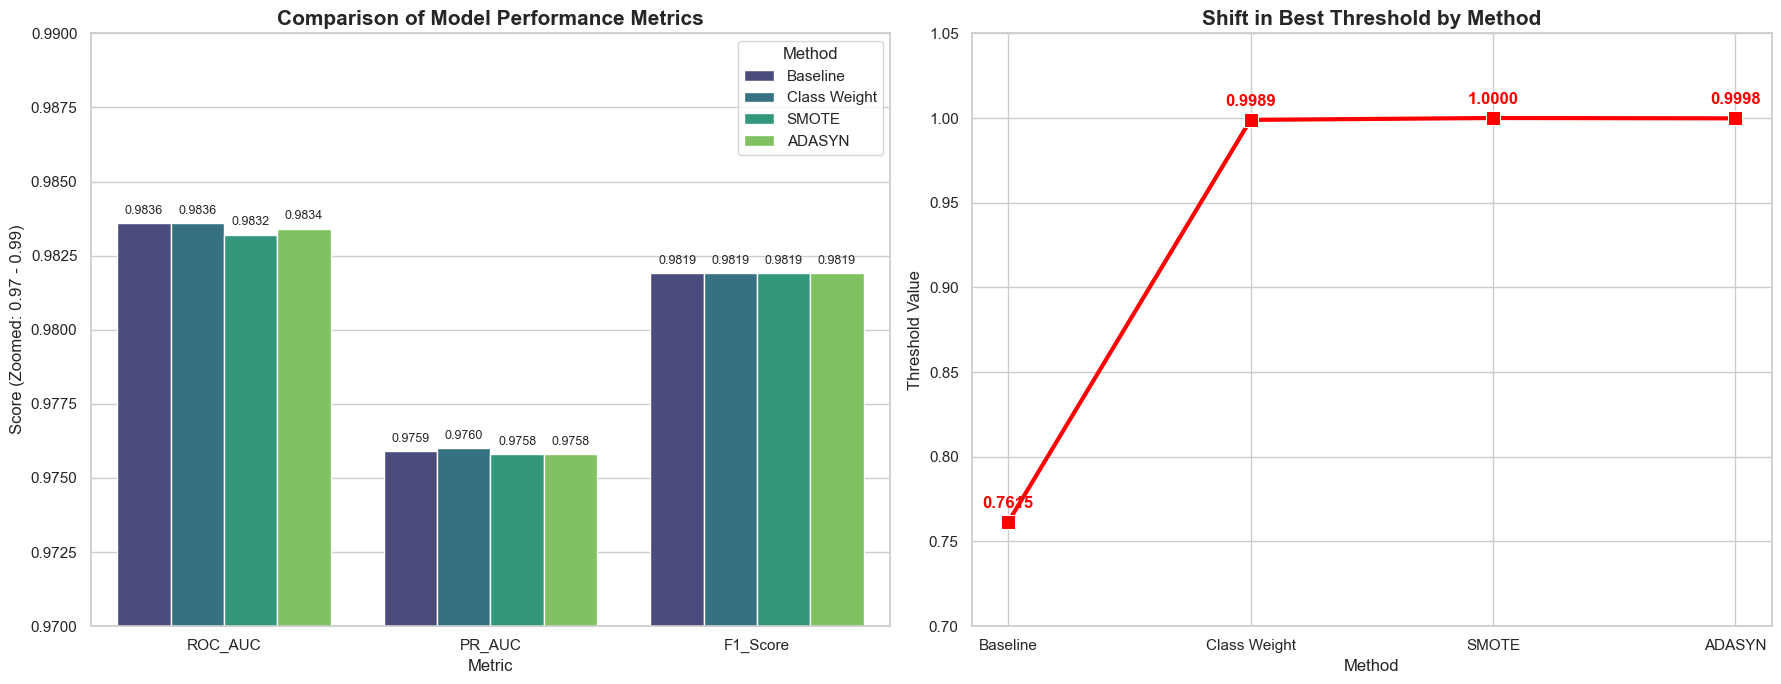

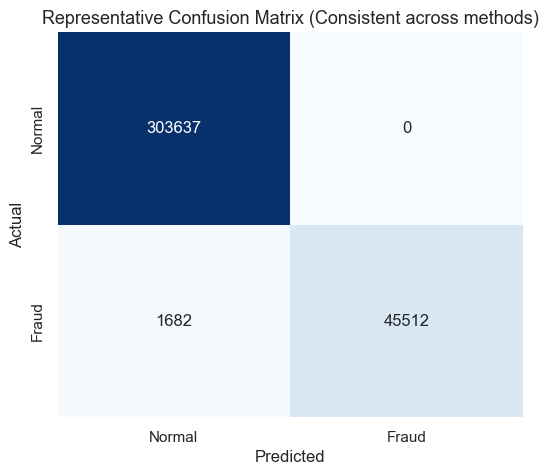

In [6]:
results = {
    'Method': ['Baseline', 'Class Weight', 'SMOTE', 'ADASYN'],
    'ROC_AUC': [0.9836, 0.9836, 0.9832, 0.9834],
    'PR_AUC': [0.9759, 0.9760, 0.9758, 0.9758],
    'F1_Score': [0.9819, 0.9819, 0.9819, 0.9819],
    'Recall': [0.9644, 0.9644, 0.9644, 0.9644],
    'Best_Threshold': [0.7615, 0.9989, 1.0000, 0.9998]
}

df_results = pd.DataFrame(results)

sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(1, 2, figsize=(18, 7))


df_melted = df_results.melt(id_vars='Method', value_vars=['ROC_AUC', 'PR_AUC', 'F1_Score'], 
                            var_name='Metric', value_name='Score')

sns.barplot(data=df_melted, x='Metric', y='Score', hue='Method', palette='viridis', ax=ax1[0])
ax1[0].set_title('Comparison of Model Performance Metrics', fontsize=15, fontweight='bold')
ax1[0].set_ylim(0.97, 0.99)  # 放大微小差異區間
ax1[0].set_ylabel('Score (Zoomed: 0.97 - 0.99)')
for p in ax1[0].patches:
    ax1[0].annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points', fontsize=9)

# --- 圖表二：最佳門檻的變動 (關鍵洞察) ---
sns.lineplot(data=df_results, x='Method', y='Best_Threshold', marker='s', markersize=10, 
             color='red', linewidth=3, ax=ax1[1])
ax1[1].set_title('Shift in Best Threshold by Method', fontsize=15, fontweight='bold')
ax1[1].set_ylabel('Threshold Value')
ax1[1].set_ylim(0.7, 1.05)
for i, txt in enumerate(df_results['Best_Threshold']):
    ax1[1].annotate(f"{txt:.4f}", (df_results['Method'][i], df_results['Best_Threshold'][i]), 
                    textcoords="offset points", xytext=(0,10), ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

# --- 圖表三：混淆矩陣可視化 (代表性) ---
plt.figure(figsize=(6, 5))
cm = np.array([[303637, 0], [1682, 45512]])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Representative Confusion Matrix (Consistent across methods)', fontsize=13)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

就「預測詐騙機率」這個目的來說，個人的看法為選擇 Class Weight Stacking 作為主力上線模型。

因為指標表現與 Baseline 幾乎完全一樣（甚至 PR-AUC 略高一點點），且模型訓練時間較 SMOTE / ADASYN 短，以及使用類別權重處理不平衡，不需要人造樣本，對風險機率的解讀與合規報告比較安全、好講清楚。
比 SMOTE / ADASYN 簡潔且更容易維護，不會在模型治理審查時被質疑「可能有大量合成資料影響風險估計真實性」。

後續會使用 Class Weight Stacking 與 Pure ensemble 方法做比較。